In [7]:
pip install Pipeline

Note: you may need to restart the kernel to use updated packages.


C:\Users\kojeo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
400 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kojeo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kojeo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kojeo\AppDa

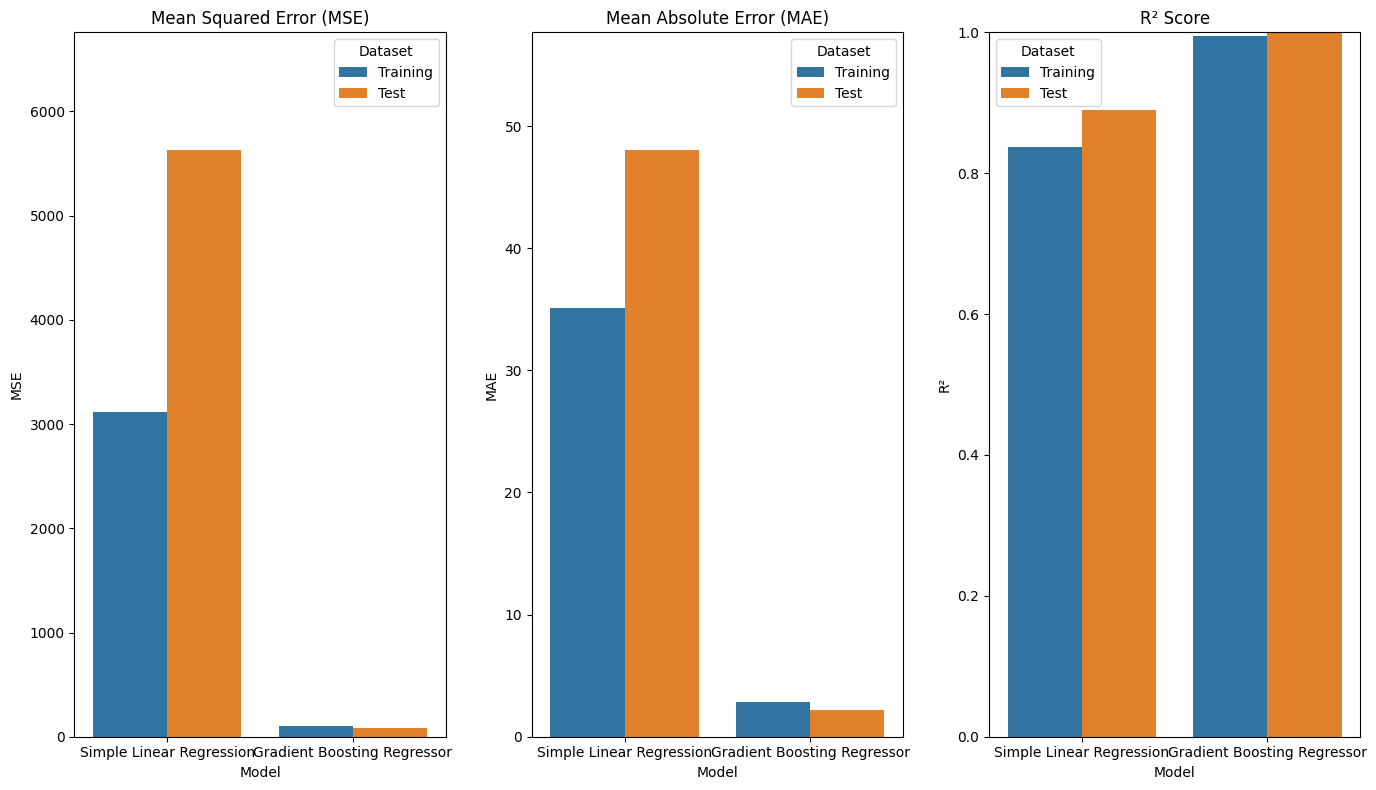

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline

# 데이터셋 가져오기
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data"
column_names = ["vendor_name", "Model_Name", "MYCT", "MMIN", "MMAX", "CACH", "CHMIN", "CHMAX", "PRP", "ERP"]
data = pd.read_csv(url, names=column_names, delimiter=",", index_col=False)

# 필요한 특성, 타겟 변수 선택
features = ["MYCT", "MMIN", "MMAX", "CACH", "CHMIN", "CHMAX"]
target = "PRP"
X = data[features]
y = data[target]

# 단순 선형 회귀 모델 학습, 평가
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)
model1 = LinearRegression()
model1.fit(X_train1, y_train1)

y_train_pred1 = model1.predict(X_train1)
train_mse1 = mean_squared_error(y_train1, y_train_pred1)
train_mae1 = mean_absolute_error(y_train1, y_train_pred1)
train_r2_1 = r2_score(y_train1, y_train_pred1)

y_test_pred1 = model1.predict(X_test1)
test_mse1 = mean_squared_error(y_test1, y_test_pred1)
test_mae1 = mean_absolute_error(y_test1, y_test_pred1)
test_r2_1 = r2_score(y_test1, y_test_pred1)

# 파이프라인을 통한 Gradient Boosting Regressor 학습, 평가하기
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(n_components=0.95)),
    ('regressor', GradientBoostingRegressor())
])

param_dist = {
    'poly__degree': [2, 3],
    'pca__n_components': [0.9, 0.95, 0.99],
    'regressor__n_estimators': randint(100, 200),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__subsample': uniform(0.7, 1.0)
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X, y)

best_model2 = random_search.best_estimator_

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_pred2 = best_model2.predict(X_train2)
train_mse2 = mean_squared_error(y_train2, y_train_pred2)
train_mae2 = mean_absolute_error(y_train2, y_train_pred2)
train_r2_2 = r2_score(y_train2, y_train_pred2)

y_test_pred2 = best_model2.predict(X_test2)
test_mse2 = mean_squared_error(y_test2, y_test_pred2)
test_mae2 = mean_absolute_error(y_test2, y_test_pred2)
test_r2_2 = r2_score(y_test2, y_test_pred2)

# 데이터프레임에 저장
performance_df1 = pd.DataFrame({
    'Model': ['Simple Linear Regression'] * 2,
    'Dataset': ['Training', 'Test'],
    'MSE': [train_mse1, test_mse1],
    'MAE': [train_mae1, test_mae1],
    'R²': [train_r2_1, test_r2_1]
})

performance_df2 = pd.DataFrame({
    'Model': ['Gradient Boosting Regressor'] * 2,
    'Dataset': ['Training', 'Test'],
    'MSE': [train_mse2, test_mse2],
    'MAE': [train_mae2, test_mae2],
    'R²': [train_r2_2, test_r2_2]
})

# 두 데이터프레임을 합치기
performance_df = pd.concat([performance_df1, performance_df2], ignore_index=True)

# 시각화
plt.figure(figsize=(14, 8))

# MSE 비교
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='MSE', hue='Dataset', data=performance_df)
plt.title('Mean Squared Error (MSE)')
plt.ylim([0, max(performance_df['MSE']) * 1.2])

# MAE 비교
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='MAE', hue='Dataset', data=performance_df)
plt.title('Mean Absolute Error (MAE)')
plt.ylim([0, max(performance_df['MAE']) * 1.2])

# R² 비교
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='R²', hue='Dataset', data=performance_df)
plt.title('R² Score')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()
